## Production model

#### This notebook will find the production model and try our best to increase score on recall by 20%. The best baseline score from AdaBoost is 0.36.

#### The step to be 

#### 1. Use high correlation features 

#### 2. Use grid search on promising model and stack good model 

#### 3. Feature engineering features & use one hot encoder


### Best model should beat baseline score and recall > 44%

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

pd.options.display.max_columns = None

#### Load data & create select features list

In [2]:
df = pd.read_csv('../data/employee_data_clean_eda.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,daily_rate_range,salary_range,monthly_rate_range,num_comp_work
0,41,1,1,1102,Sales,1,2,Life Sciences,2,0,94,3,2,Sales Executive,4,0,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,1100,6250,18750,7.5
1,49,0,1,279,Research & Development,8,1,Life Sciences,3,1,61,2,2,Research Scientist,2,1,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,300,6250,21250,2.5
2,37,1,1,1373,Research & Development,2,2,Other,4,1,92,2,1,Laboratory Technician,3,0,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1400,1250,1250,7.5
3,33,0,1,1392,Research & Development,3,4,Life Sciences,4,0,56,3,1,Research Scientist,3,1,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1400,3750,21250,2.5
4,27,0,1,591,Research & Development,2,1,Medical,1,1,40,3,1,Laboratory Technician,2,1,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,600,3750,16250,7.5


In [3]:
# delete
set(df['StockOptionLevel'])

{0, 1, 2, 3}

In [4]:
# delete
df['StockOptionLevel'].value_counts()

0    630
1    595
2    158
3     85
Name: StockOptionLevel, dtype: int64

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/yr/lt5kfbcj2vs6bwkkyhxsp_0c0000gn/T/ipykernel_30525/2001914525.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,daily_rate_range,salary_range,monthly_rate_range,num_comp_work
Age,1.00,-0.17,0.01,0.02,-0.00,0.21,0.01,-0.04,0.02,0.03,0.51,-0.01,0.08,0.50,0.03,0.30,0.03,0.01,0.00,0.05,0.04,0.68,-0.02,-0.02,0.30,0.21,0.21,0.20,0.01,0.50,0.03,0.17
Attrition,-0.17,1.00,0.07,-0.05,0.08,-0.03,-0.11,0.03,-0.01,-0.13,-0.18,-0.10,-0.09,-0.17,0.02,0.04,0.25,-0.01,0.00,-0.05,-0.14,-0.18,-0.06,-0.06,-0.15,-0.17,-0.04,-0.16,-0.05,-0.17,0.01,0.08
BusinessTravel,0.01,0.07,1.00,-0.01,-0.02,-0.01,-0.00,-0.05,0.02,0.05,0.01,-0.02,0.04,0.02,-0.02,-0.00,0.04,-0.04,-0.02,-0.02,-0.03,0.03,0.02,-0.01,-0.01,-0.01,-0.02,-0.02,-0.01,0.02,-0.01,-0.00
DailyRate,0.02,-0.05,-0.01,1.00,-0.00,-0.01,0.02,-0.01,0.02,0.05,0.01,0.03,0.04,0.01,-0.03,0.04,0.01,0.02,-0.00,0.01,0.04,0.02,0.00,-0.04,-0.03,0.01,-0.03,-0.02,1.00,0.02,-0.03,0.03
DistanceFromHome,-0.00,0.08,-0.02,-0.00,1.00,0.02,-0.02,0.00,0.03,0.01,0.01,-0.01,0.03,-0.02,0.03,-0.03,0.03,0.04,0.03,0.01,0.04,0.00,-0.04,-0.03,0.01,0.02,0.01,0.01,-0.00,-0.02,0.02,-0.04
Education,0.21,-0.03,-0.01,-0.01,0.02,1.00,-0.03,-0.02,0.02,0.04,0.10,-0.01,-0.00,0.09,-0.03,0.13,-0.02,-0.01,-0.02,-0.01,0.02,0.14,-0.02,0.01,0.06,0.06,0.05,0.07,-0.01,0.09,-0.02,0.07
EnvironmentSatisfaction,0.01,-0.11,-0.00,0.02,-0.02,-0.03,1.00,0.00,-0.05,-0.01,-0.00,-0.01,-0.02,-0.01,0.04,0.01,0.07,-0.03,-0.03,0.01,0.00,-0.01,-0.02,0.03,-0.01,0.01,0.01,-0.01,0.02,-0.02,0.04,0.01
Gender,-0.04,0.03,-0.05,-0.01,0.00,-0.02,0.00,1.00,0.00,0.02,-0.04,0.03,-0.01,-0.03,-0.04,-0.04,-0.04,0.00,-0.01,0.02,0.01,-0.05,-0.04,-0.00,-0.03,-0.04,-0.03,-0.03,-0.01,-0.04,-0.04,-0.03
HourlyRate,0.02,-0.01,0.02,0.02,0.03,0.02,-0.05,0.00,1.00,0.04,-0.03,-0.07,0.03,-0.01,-0.01,0.02,-0.01,-0.01,-0.00,0.00,0.05,-0.00,-0.01,-0.00,-0.02,-0.02,-0.03,-0.02,0.02,-0.01,-0.01,0.04
JobInvolvement,0.03,-0.13,0.05,0.05,0.01,0.04,-0.01,0.02,0.04,1.00,-0.01,-0.02,0.03,-0.02,-0.02,0.01,-0.00,-0.02,-0.03,0.03,0.02,-0.01,-0.02,-0.01,-0.02,0.01,-0.03,0.03,0.04,-0.01,-0.01,-0.01


In [6]:
corr = df.corr()[['Attrition']].sort_values(by='Attrition', ascending=False)

corr.style.background_gradient(cmap='coolwarm').set_precision(2) 
# Got how to do precision from: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

/var/folders/yr/lt5kfbcj2vs6bwkkyhxsp_0c0000gn/T/ipykernel_30525/4018168608.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Attrition
Attrition,1.00
OverTime,0.25
DistanceFromHome,0.08
num_comp_work,0.08
BusinessTravel,0.07
NumCompaniesWorked,0.04
Gender,0.03
MonthlyRate,0.02
monthly_rate_range,0.01
PerformanceRating,0.00


In [7]:
# select one that correlation over +/- 10%
selected_features = [
    'Age',
    'BusinessTravel',
    'Department',
    'DistanceFromHome',
    'EducationField',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobRole', # category
    'JobSatisfaction',
    'MaritalStatus',
    'salary_range', # will test between MonthlyIncome
    'NumCompaniesWorked',
    'num_comp_work',
    'OverTime', # (*****+25%)
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TotalWorkingYears', # (****-18%)
    'TrainingTimesLastYear',
    'WorkLifeBalance', # (****4)
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsWithCurrManager'
]

In [8]:
selected_features = [
    'Age',
    'BusinessTravel',
    'Department',
    'DistanceFromHome',
    'EducationField',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobRole',
    'JobSatisfaction',
    'MaritalStatus',
    'salary_range',
    'NumCompaniesWorked',
    'num_comp_work',
    'OverTime',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'WorkLifeBalance',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsWithCurrManager'
]

In [9]:
df[selected_features].columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'salary_range', 'NumCompaniesWorked', 'num_comp_work', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsWithCurrManager'],
      dtype='object')

#### Train Test Split

In [10]:
X = df[selected_features]
y = df['Attrition']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)
# save data for hyper tuning
with open('pickle/df_y_train', 'wb') as f:
    pickle.dump(y_train,f) 
with open('pickle/df_y_test', 'wb') as f:
    pickle.dump(y_test,f) 

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1247, 23), (221, 23), (1247,), (221,))

### Create Dummies

#### - List all object columns

In [13]:
# Check all object categories
glimpse = []
for c in df.columns:
    make_set = list(set(df[c]))
    data = {'column_name':c, 'set_10':make_set[:10], 'set_count':len(make_set), 'type':str(df[c].dtypes)}
    #glimpse.append(data)
    if data['type'] == 'object':
        glimpse.append(data)
df_glimpse = pd.DataFrame(glimpse)
df_glimpse

,column_name,set_10,set_count,type
0,Department,"[Sales, Human Resources, Research & Development]",3,object
1,EducationField,"[Medical, Human Resources, Technical Degree, M...",6,object
2,JobRole,"[Manager, Human Resources, Sales Representativ...",9,object


In [14]:
dummy_col = [c for c in df_glimpse['column_name'] if c in selected_features]

dummy_col

['Department', 'EducationField', 'JobRole']

In [15]:
X_train_dum = pd.get_dummies(X_train, columns=dummy_col) # drop_first=True increase train score but drop the test score
X_test_dum = pd.get_dummies(X_test, columns=dummy_col) # drop_first=True increase train score but drop the test score

X_train_dum.shape, X_test_dum.shape

((1247, 38), (221, 38))

#### Modeling with dummies

In [16]:
# function for iterate models
def model_processing(model, X_train, X_test, y_train, y_test):
    scores = []
    cm_train = []
    cm_test = []
    for m in model:
        m.fit(X_train, y_train)
        model_name = type(m).__name__
        scores.append([model_name, m.score(X_train, y_train), m.score(X_test, y_test)])
        
        cm_train.append([model_name, confusion_matrix(y_train, m.predict(X_train))])
        cm_test.append([model_name, confusion_matrix(y_test, m.predict(X_test))])
    return scores, cm_train, cm_test
# Got how to get model name from: https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn

In [17]:
# function to print confusion matrix scores
def print_score(cm, is_print=False):
    tn, fp, fn, tp = cm.ravel()
    # calculate accuracy
    conf_accuracy = (float (tp+tn) / float(tp + tn + fp + fn))
    
    # calculate the recall
    conf_recall = (tp / float(tp + fn))

    if is_print:
        decimal = 3
        print(f'Accuracy: \t{round(conf_accuracy,decimal)}') 
        print(f'Recall: \t{round(conf_recall,decimal)}') 
    return conf_accuracy, conf_recall

In [18]:
def confusion_matrix_score(cm, is_print=False):
    cm_scores = []
    for c in cm:
        tn, fp, fn, tp = c[1].ravel()
        acc = (float (tp+tn) / float(tp + tn + fp + fn))
        rcl = (tp / float(tp + fn))
        if is_print:
            print(c[0], ': Accuracy =', acc, ', Recall =', rcl)
        cm_scores.append([c[0], acc, rcl, tn, fp, fn, tp])
    return cm_scores

In [19]:
# process all models - DUMMY
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
knn = KNeighborsClassifier()
model = [lr, rf, ada, knn]
scores, cm_train, cm_test = model_processing(model, X_train_dum, X_test_dum, y_train, y_test)

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

In [20]:
pd.DataFrame(scores, columns=['model', 'train_score', 'test_score'])

,model,train_score,test_score
0,LogisticRegression,0.844427,0.855204
1,RandomForestClassifier,1.000000,0.850679
2,AdaBoostClassifier,0.901363,0.873303
3,KNeighborsClassifier,0.874900,0.832579


In [21]:
cm_scores_train = confusion_matrix_score(cm_train)

df_cm_train = pd.DataFrame(cm_scores_train, columns=['model', 'train_accuracy', 'train_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_train.to_csv('../data/cm_scores_train.csv', index=False)
df_cm_train['precision'] = df_cm_train['tp'] / (df_cm_train['tp'] + df_cm_train['fp'])
df_cm_train['F1-score'] = (2 * df_cm_train['train_recall'] * df_cm_train['precision'])/(df_cm_train['train_recall']+df_cm_train['precision'])
df_cm_train

,model,train_accuracy,train_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.844427,0.060,1041,6,188,12,0.666667,0.110092
1,RandomForestClassifier,1.000000,1.000,1047,0,0,200,1.000000,1.000000
2,AdaBoostClassifier,0.901363,0.470,1030,17,106,94,0.846847,0.604502
3,KNeighborsClassifier,0.874900,0.305,1030,17,139,61,0.782051,0.438849


In [22]:
cm_scores_test = confusion_matrix_score(cm_test)

df_cm_test = pd.DataFrame(cm_scores_test, columns=['model', 'test_accuracy', 'test_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_test.to_csv('../data/cm_scores_test.csv', index=False)
df_cm_test['precision'] = df_cm_test['tp'] / (df_cm_test['tp'] + df_cm_test['fp'])
df_cm_test['F1-score'] = (2 * df_cm_test['test_recall'] * df_cm_test['precision'])/(df_cm_test['test_recall'] + df_cm_test['precision'])
df_cm_test

,model,test_accuracy,test_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.855204,0.085714,186,0,32,3,1.000000,0.157895
1,RandomForestClassifier,0.850679,0.142857,183,3,30,5,0.625000,0.232558
2,AdaBoostClassifier,0.873303,0.428571,178,8,20,15,0.652174,0.517241
3,KNeighborsClassifier,0.832579,0.142857,179,7,30,5,0.416667,0.212766


#### Until now, if we look at AdaBoostClassifier, our model F1-score better that baseline 0.52/0.45 = 1.15 or 15%

##### Next, we'll try OneHotEncoder and StandardScaler to see if the score improve

##### Then We'll skip to working on Streamlit then after that we'll go back to do some hypertuning to see if the score can be improve.

#### OneHotEncoder

In [23]:
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

#X_train_enc.shape, X_test_enc.shape

In [24]:
# process all models - OHE
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
knn = KNeighborsClassifier()
model = [lr, rf, ada, knn]
scores, cm_train, cm_test = model_processing(model, X_train_ohe, X_test_ohe, y_train, y_test)

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

In [25]:
pd.DataFrame(scores, columns=['model', 'train_score', 'test_score'])

,model,train_score,test_score
0,LogisticRegression,0.921411,0.850679
1,RandomForestClassifier,1.000000,0.868778
2,AdaBoostClassifier,0.896552,0.864253
3,KNeighborsClassifier,0.887731,0.832579


In [26]:
cm_scores_train = confusion_matrix_score(cm_train)

df_cm_train = pd.DataFrame(cm_scores_train, columns=['model', 'train_accuracy', 'train_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_train.to_csv('../data/cm_scores_train.csv', index=False)
df_cm_train['precision'] = df_cm_train['tp'] / (df_cm_train['tp'] + df_cm_train['fp'])
df_cm_train['F1-score'] = (2 * df_cm_train['train_recall'] * df_cm_train['precision'])/(df_cm_train['train_recall']+df_cm_train['precision'])
df_cm_train

,model,train_accuracy,train_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.921411,0.590,1031,16,82,118,0.880597,0.706587
1,RandomForestClassifier,1.000000,1.000,1047,0,0,200,1.000000,1.000000
2,AdaBoostClassifier,0.896552,0.485,1021,26,103,97,0.788618,0.600619
3,KNeighborsClassifier,0.887731,0.375,1032,15,125,75,0.833333,0.517241


In [27]:
cm_scores_test = confusion_matrix_score(cm_test)

df_cm_test = pd.DataFrame(cm_scores_test, columns=['model', 'test_accuracy', 'test_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_test.to_csv('../data/cm_scores_test.csv', index=False)
df_cm_test['precision'] = df_cm_test['tp'] / (df_cm_test['tp'] + df_cm_test['fp'])
df_cm_test['F1-score'] = (2 * df_cm_test['test_recall'] * df_cm_test['precision'])/(df_cm_test['test_recall'] + df_cm_test['precision'])
df_cm_test

,model,test_accuracy,test_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.850679,0.428571,173,13,20,15,0.535714,0.476190
1,RandomForestClassifier,0.868778,0.200000,185,1,28,7,0.875000,0.325581
2,AdaBoostClassifier,0.864253,0.428571,176,10,20,15,0.600000,0.500000
3,KNeighborsClassifier,0.832579,0.200000,177,9,28,7,0.437500,0.274510


#### StandardScaler + OHE

https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set

In [28]:
len(selected_features)

23

In [29]:
numerical_features = [c for c in selected_features if c not in dummy_col]

len(numerical_features)

20

In [30]:
ct = ColumnTransformer([
        ('sc', StandardScaler(), numerical_features),
        ('ohe', OneHotEncoder(), dummy_col)
    ], remainder='passthrough')

X_train_ct = ct.fit_transform(X_train[selected_features])
X_test_ct = ct.transform(X_test[selected_features])

# save data for hyper tuning
with open('pickle/df_X_train_ct', 'wb') as f:
    pickle.dump(X_train_ct,f) 
with open('pickle/df_X_test_ct', 'wb') as f:
    pickle.dump(X_test_ct,f)
with open('pickle/df_y_train', 'wb') as f:
    pickle.dump(y_train,f) 
with open('pickle/df_y_test', 'wb') as f:
    pickle.dump(y_test,f) 

X_train_ct.shape, X_test_ct.shape

((1247, 38), (221, 38))

In [31]:
# process all models - CT(SC,OHE)
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
knn = KNeighborsClassifier()
model = [lr, rf, ada, knn]
scores, cm_train, cm_test = model_processing(model, X_train_ct, X_test_ct, y_train, y_test)

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

In [32]:
pd.DataFrame(scores, columns=['model', 'train_score', 'test_score'])

,model,train_score,test_score
0,LogisticRegression,0.898957,0.859729
1,RandomForestClassifier,1.000000,0.850679
2,AdaBoostClassifier,0.901363,0.873303
3,KNeighborsClassifier,0.881315,0.841629


In [33]:
cm_scores_train = confusion_matrix_score(cm_train)

df_cm_train = pd.DataFrame(cm_scores_train, columns=['model', 'train_accuracy', 'train_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_train.to_csv('../data/cm_scores_train.csv', index=False)
df_cm_train['precision'] = df_cm_train['tp'] / (df_cm_train['tp'] + df_cm_train['fp'])
df_cm_train['F1-score'] = (2 * df_cm_train['train_recall'] * df_cm_train['precision'])/(df_cm_train['train_recall']+df_cm_train['precision'])
df_cm_train

,model,train_accuracy,train_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.898957,0.460,1029,18,108,92,0.836364,0.593548
1,RandomForestClassifier,1.000000,1.000,1047,0,0,200,1.000000,1.000000
2,AdaBoostClassifier,0.901363,0.470,1030,17,106,94,0.846847,0.604502
3,KNeighborsClassifier,0.881315,0.315,1036,11,137,63,0.851351,0.459854


In [34]:
cm_scores_test = confusion_matrix_score(cm_test)

df_cm_test = pd.DataFrame(cm_scores_test, columns=['model', 'test_accuracy', 'test_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_test.to_csv('../data/cm_scores_test.csv', index=False)
df_cm_test['precision'] = df_cm_test['tp'] / (df_cm_test['tp'] + df_cm_test['fp'])
df_cm_test['F1-score'] = (2 * df_cm_test['test_recall'] * df_cm_test['precision'])/(df_cm_test['test_recall'] + df_cm_test['precision'])
df_cm_test

,model,test_accuracy,test_recall,tn,fp,fn,tp,precision,F1-score
0,LogisticRegression,0.859729,0.342857,178,8,23,12,0.600000,0.436364
1,RandomForestClassifier,0.850679,0.142857,183,3,30,5,0.625000,0.232558
2,AdaBoostClassifier,0.873303,0.428571,178,8,20,15,0.652174,0.517241
3,KNeighborsClassifier,0.841629,0.114286,182,4,31,4,0.500000,0.186047


#### Try XGBoost

In [35]:
xgb = XGBClassifier()
model = [xgb]
scores, cm_train, cm_test = model_processing(model, X_train_ct, X_test_ct, y_train, y_test)
cm_scores_test = confusion_matrix_score(cm_test)
cm_scores_train = confusion_matrix_score(cm_train)

pd.DataFrame(scores, columns=['model', 'train_score', 'test_score'])

,model,train_score,test_score
0,XGBClassifier,1.0,0.864253


In [36]:
df_cm_train = pd.DataFrame(cm_scores_train, columns=['model', 'train_accuracy', 'train_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_train.to_csv('../data/cm_scores_train.csv', index=False)
df_cm_train

,model,train_accuracy,train_recall,tn,fp,fn,tp
0,XGBClassifier,1.0,1.0,1047,0,0,200


In [37]:
df_cm_test = pd.DataFrame(cm_scores_test, columns=['model', 'test_accuracy', 'test_recall', 'tn', 'fp', 'fn', 'tp'])
df_cm_test.to_csv('../data/cm_scores_test.csv', index=False)
df_cm_test['precision'] = df_cm_test['tp'] / (df_cm_test['tp'] + df_cm_test['fp'])
df_cm_test['F1-score'] = (2 * df_cm_test['test_recall'] * df_cm_test['precision'])/(df_cm_test['test_recall'] + df_cm_test['precision'])
df_cm_test

,model,test_accuracy,test_recall,tn,fp,fn,tp,precision,F1-score
0,XGBClassifier,0.864253,0.371429,178,8,22,13,0.619048,0.464286


In [38]:
cm_test[0][1]

array([[178,   8],
       [ 22,  13]])

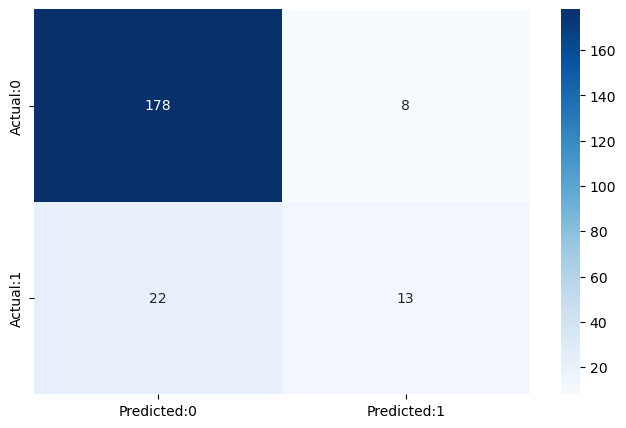

In [39]:
conf_matrix=pd.DataFrame(data=cm_test[0][1],columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap=plt.cm.Blues);

### The best production score came from the AdaBoost model

### Recall .43 (baseline .36)

### Precision .65 (baseline .59)

### F1-score .52 (baseline 45.) +15%